In [3]:
import numpy as np
import matplotlib.pyplot as plt
from quimb import *
from scipy import sparse
from quimb.linalg.base_linalg import *
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from scipy.linalg import expm
from qiskit.quantum_info import Operator

In [53]:
N = 4 #Number of qubits

J = np.zeros((N,N))
for i in range(N-1):
    J[i,i+1] = np.random.choice([-1, 1])

print(J)

I, X, Y, Z = (pauli(s) for s in 'IXYZ')

def dis_ising(J,N):
    M = 2**N # DImension of hilbert space
    H = np.zeros((M,M))
    for i in range(N-1):
        H = H + J[i,i+1]*ikron(Z,dims = [2]*N,inds = [i,i+1])
    return H

H = dis_ising(J, N)
# U = expm(H*dt)

gs = groundstate(H)
# print(gs)
# test_state = kron(up(), down(), up(), up())
# print(expec(test_state, H))

#m = np.zeros((N))
#for i in range(N):
#    rho_red = ptr(gs,dims = [2]*N, keep = i)
#    m[i] = expec(Z,rho_red)
#print(m)


analytical_groundstate_energy = expec(H,gs)
print("Lowest energy from exact Diagonalisation is = ", analytical_groundstate_energy)

[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0.  0.  0.]]
Lowest energy from exact Diagonalisation is =  -3.0


In [55]:
r =np.random.random()
print(r)


0.7148092955521028


In [56]:

def scaling(x):
        return x**2 #Linear Scaling
def a(t):
    a = scaling(t)
    return a
def b(t):
    b = 1 - scaling(t)
    return b

def GSA_approx(T,L,J):
    dt = T/L          # time step
    ts = np.linspace(0, T, L)
    qc = QuantumCircuit(N)
    r = np.random.random()
    error_qubit = np.random.randint(0,N-1)
    if r < 1/4:
            qc.i(error_qubit)
    elif 1/4<=r<1/2:
        qc.x(error_qubit)
    elif 1/2<=r<3/4:
        qc.y(error_qubit)
    elif 3/4<=r<=1:
        qc.z(error_qubit)
    for qubit in range(0, N): # creating uniform superposition
        qc.h(qubit)
    r = np.random.random()
    error_qubit = np.random.randint(0,N-1)
    if r < 1/4:
        qc.i(error_qubit)
    elif 1/4<=r<1/2:
        qc.x(error_qubit)
    elif 1/2<=r<3/4:
        qc.y(error_qubit)
    elif 3/4<=r<=1:
        qc.z(error_qubit)
    for k in range(L):
        for i in range(N-2, -1, -2): #even bonds
            j = i+1
            qc.rzz(-np.pi * a(k/L) * J[i, j] * dt, j, i)
        r = np.random.random()
        error_qubit = np.random.randint(0,N-1)
        if r < 1/4:
            qc.i(error_qubit)
        elif 1/4<=r<1/2:
            qc.x(error_qubit)
        elif 1/2<=r<3/4:
            qc.y(error_qubit)
        elif 3/4<=r<=1:
            qc.z(error_qubit)
        for i in range(0, N, 2): #even bonds      # H_D = uniform X field as the Driver Hamiltonian
            qc.rx(np.pi * b(k/L) * dt, i)
        r = np.random.random()
        error_qubit = np.random.randint(0,N-1)
        if r < 1/4:
            qc.i(error_qubit)
        elif 1/4<=r<1/2:
            qc.x(error_qubit)
        elif 1/2<=r<3/4:
            qc.y(error_qubit)
        elif 3/4<=r<=1:
            qc.z(error_qubit)
        for i in range(N-3, -1, -2): #odd bonds
            j = i+1
            qc.rzz(-np.pi * a(k/L) * J[i, j] * dt, j, i)
        r = np.random.random()
        error_qubit = np.random.randint(0,N-1)
        if r < 1/4:
            qc.i(error_qubit)
        elif 1/4<=r<1/2:
            qc.x(error_qubit)
        elif 1/2<=r<3/4:
            qc.y(error_qubit)
        elif 3/4<=r<=1:
            qc.z(error_qubit)
        for i in range(1, N-1, 2): #odd bonds      # H_D = uniform X field as the Driver Hamiltonian
            qc.rx(np.pi * b(k/L) * dt, i)
        r = np.random.random()
        error_qubit = np.random.randint(0,N-1)
        if r < 1/4:
            qc.i(error_qubit)
        elif 1/4<=r<1/2:
            qc.x(error_qubit)
        elif 1/2<=r<3/4:
            qc.y(error_qubit)
        elif 3/4<=r<=1:
            qc.z(error_qubit)
    qc.measure_all()
    num_shots_per_point = 100
    sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, sim)
    counts = sim.run(t_qc, shots=num_shots_per_point).result().get_counts()
    expectation_z = 0
    for key in counts:
        bitstring = key
        for m in range(N-1, 0, -1):
            expectation_z += J[N-m-1, N-m]*(int(counts[key]) * (-1) ** (int(bitstring[m-1]) + int(bitstring[m])))
    expectation_z = expectation_z / num_shots_per_point
    return expectation_z







In [57]:
T = 20*np.pi       #final time
L = 100
#number of time steps
GSA_approx(T,L,J)

0.52

In [ ]:
Tlist= np.linspace(10*np.pi,40*np.pi,30)
error_shots = 1000
L = 100

approx = np.zeros((30))
for i in range(30):
    print(i)
    for j in range(error_shots):
        approx[i]= approx[i]+ np.abs(np.abs(analytical_groundstate_energy)-np.abs(GSA_approx(Tlist[i],L,J)))
    approx[i] = approx[i]/error_shots

0


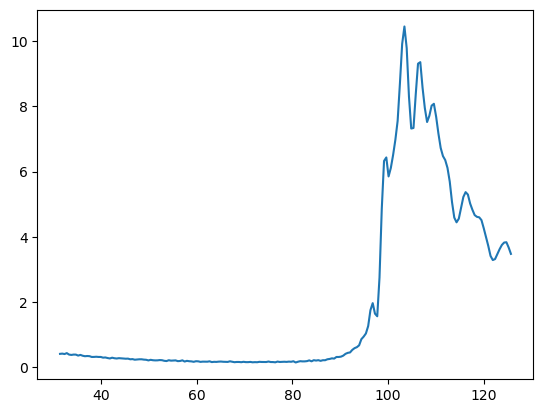

In [58]:
plt.plot(Tlist,approx)
plt.show()